In [2]:
#Uncomment this line if you are connecting to Google Drive to access the files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import Standard Libraries**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
seed = 277268
random.seed(seed)

import nltk
import gensim
import gensim.downloader as api
from sklearn.metrics import classification_report
import torch.optim as optim
from nltk.tokenize import word_tokenize
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
from sklearn import metrics
import torch
import numpy as np
from torch import nn
from transformers import BertTokenizer, BertModel
from torch.optim import Adam
from tqdm import tqdm
import gc
import spacy
import string

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
#Set seed to ensure the code and outputs are reproducible
torch.manual_seed(seed)

#Cuda algorithms
torch.backends.cudnn.deterministic = True

In [6]:
#Clear CUDA cache to free up memory
torch.cuda.empty_cache()

In [7]:
#Adapted the code from AdvNlp week 10
#Check if NVIDIA GPU is available
#If yes, use CUDA to perform computations
use_cuda = torch.cuda.is_available()

if use_cuda:
    print("GPU acceleration enabled")
else:
    print("GPU acceleration NOT enabled. If using Colab, have you changed the runtime type and selected GPU as the hardware accelerator?")

device = torch.device("cuda" if use_cuda else "cpu")
print(device)

GPU acceleration enabled
cuda


# Reading the data in training and validation datasets

In [8]:
df_train_input = pd.read_csv('/content/drive/MyDrive/propaganda_train.tsv', delimiter='\t', quotechar='|')
df_train_input['label'] = df_train_input['label'].str.strip()
print(f'No. of records in the training dataset:{df_train_input.count()}')
df_train_input.head(5)

No. of records in the training dataset:label                2560
tagged_in_context    2560
dtype: int64


,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,"""The Obama administration misled the <BOS> Ame..."
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"


In [9]:
df_validation = pd.read_csv('/content/drive/MyDrive/propaganda_val.tsv', delimiter='\t', quotechar='|')
df_validation['label'] = df_validation['label'].str.strip()
print(f'No. of records in the validation dataset:{df_validation.count()}')
df_validation.head(5)

No. of records in the validation dataset:label                640
tagged_in_context    640
dtype: int64


,label,tagged_in_context
0,not_propaganda,"On average, between 300 and 600 infections are..."
1,causal_oversimplification,Mostly because <BOS> the country would not las...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.
4,repetition,It must be exacted from him directly in order ...


The specific type of propangada label is not necessary in binary categorization. Instead, all that has to be done is ascertain whether or not something is propaganda. I will create a new field specifically for the binary classification operation.

In [10]:
df_train_input['binary_label'] = df_train_input['label'].map(lambda x: 'propaganda' if x != 'not_propaganda' else x)
df_validation['binary_label'] = df_validation['label'].map(lambda x: 'propaganda' if x != 'not_propaganda' else x)

## **Check the distribution of Training data**

In [11]:
df_train_input

,label,tagged_in_context,binary_label
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed.",not_propaganda
1,not_propaganda,This declassification effort <BOS> won’t make ...,not_propaganda
2,flag_waving,"""The Obama administration misled the <BOS> Ame...",propaganda
3,not_propaganda,“It looks like we’re capturing the demise of t...,not_propaganda
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>",not_propaganda
...,...,...,...
2555,not_propaganda,<BOS> We support and appreciate <EOS> your bus...,not_propaganda
2556,not_propaganda,International Atomic Energy Agency (IAEA) Dire...,not_propaganda
2557,not_propaganda,What has been done: there has been work on for...,not_propaganda
2558,not_propaganda,This is <BOS> the law of gradualness not the g...,not_propaganda


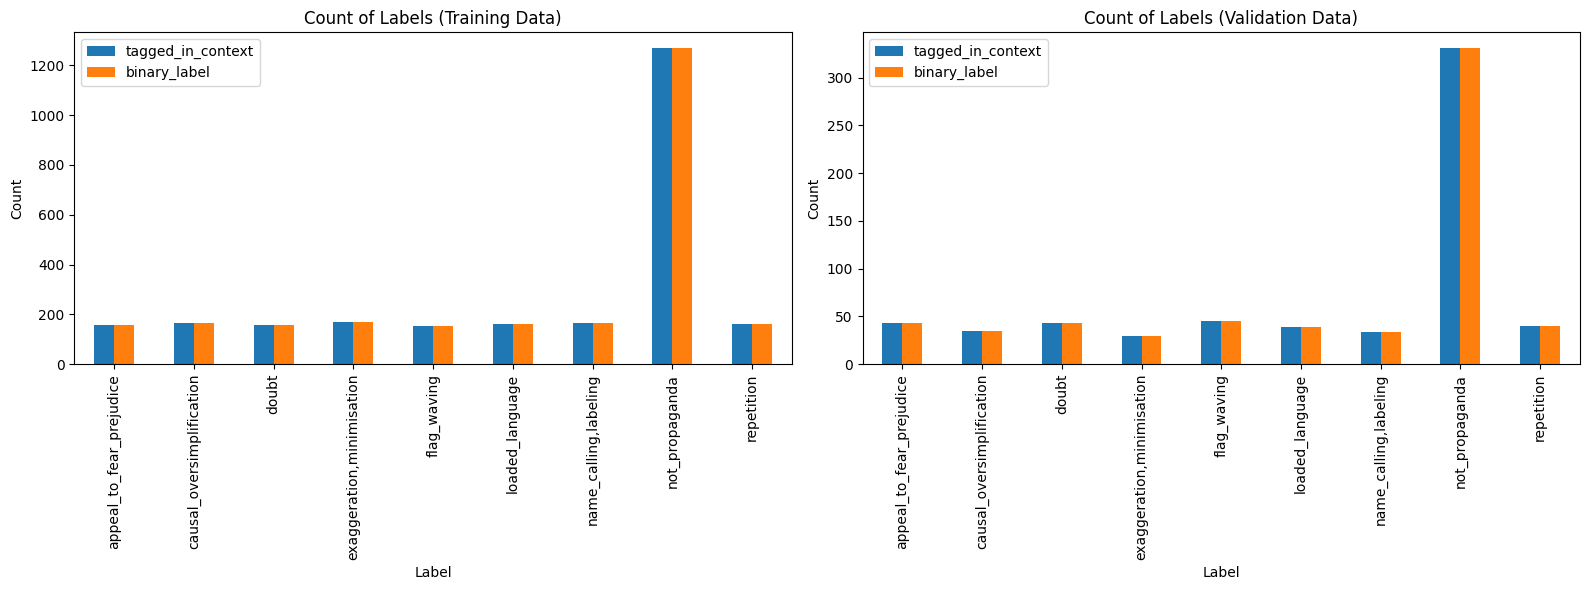

In [12]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot for training data
df_train_input.groupby('label').count().plot(kind='bar', ax=ax1)
ax1.set_xlabel('Label')
ax1.set_ylabel('Count')
ax1.set_title('Count of Labels (Training Data)')
ax1.tick_params(axis='x', rotation=90)

# Plot for validation data
df_validation.groupby('label').count().plot(kind='bar', ax=ax2)
ax2.set_xlabel('Label')
ax2.set_ylabel('Count')
ax2.set_title('Count of Labels (Validation Data)')
ax2.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [13]:
df_train_input.groupby('binary_label').count()

,label,tagged_in_context
binary_label,,
not_propaganda,1269,1269
propaganda,1291,1291


Taking into account the binary classification Task 1, the training dataset is balanced. Since there are only two possible outcomes—"propaganda" or "not_propaganda"—we can only predict whether the text belongs to one of the two classes in this binary classification test. The dataset is balanced for multiclass classification Task 2 since we just need to predict the type of propaganda included in the text and take into account texts that contain propaganda. Hence, the dataset is balanced since we can eliminate the "not_propaganda" rows. The training dataset will now be divided into distinct train and test datasets by me. Twenty percent of the data that are currently in the training class will be included in the testing dataset.


In [14]:
#Split the data into train and test sets.
df_train, df_test = train_test_split(df_train_input, test_size=0.2, random_state=seed)
df_test

,label,tagged_in_context,binary_label
354,not_propaganda,“More than one third of Iran’s population is m...,not_propaganda
878,not_propaganda,Those who argue for its abolition do not neces...,not_propaganda
2045,not_propaganda,"To thank him for his service, Campbell was pai...",not_propaganda
2444,doubt,<BOS> He didn’t provide any support for his cl...,propaganda
2062,not_propaganda,“She knew this would have a huge effect <BOS> ...,not_propaganda
...,...,...,...
2187,"name_calling,labeling","In obedience, strive to live out your priestho...",propaganda
2489,not_propaganda,"In a statement, Ellison thanked Ellingstad for...",not_propaganda
1583,not_propaganda,Yore said that given the Church’s sex abuse cr...,not_propaganda
1526,"exaggeration,minimisation","Its pages, however, are readily available to t...",propaganda


# **Task 1 - Binary Classification**

In [15]:
#Select the required columns
df_train_binary_classification = df_train[['tagged_in_context', 'binary_label']].copy()
df_test_binary_classification = df_test[['tagged_in_context', 'binary_label']].copy()
df_validation_binary_classification = df_validation[['tagged_in_context', 'binary_label']].copy()

In [16]:
#Binary Classification labels
binary_labels = {label:i for i,label in enumerate(df_train_binary_classification['binary_label'].sort_values().unique().tolist())}
binary_labels

{'not_propaganda': 0, 'propaganda': 1}

In [17]:
#Build a reverse index dictionary for easy lookup.
reverse_index_binary_label ={v:k for (k,v) in binary_labels.items()}
reverse_index_binary_label

{0: 'not_propaganda', 1: 'propaganda'}

# **1.1 Bag of words classifier**

In [18]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


# Initialize CountVectorizer
vectorizer = CountVectorizer()
# Tokenize the text
x_train = vectorizer.fit_transform(df_train_input['tagged_in_context'])
y_train = df_train_input['binary_label']
x_test = vectorizer.transform(df_validation['tagged_in_context'])
y_test = df_validation['binary_label']


# Choose a binary classifier algorithm
classifier = LogisticRegression(max_iter=1000)

# Train the classifier
classifier.fit(x_train, y_train)

# Evaluate the classifier
y_pred = classifier.predict(x_test)

# Report the accuracy and other metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.725
Classification Report:
                precision    recall  f1-score   support

not_propaganda       0.71      0.78      0.75       331
    propaganda       0.74      0.66      0.70       309

      accuracy                           0.73       640
     macro avg       0.73      0.72      0.72       640
  weighted avg       0.73      0.72      0.72       640



## **1.1.1 Hypertuning bag of words classifer**

In [19]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import uniform
from sklearn.exceptions import ConvergenceWarning
import warnings

#Define the hyperparameter distribution
param_dist = {
    'C': uniform(loc=0.1, scale=10),
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2']
}

# Suppress the ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Perform randomized search
random_search = RandomizedSearchCV(LogisticRegression(max_iter=1000), param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search.fit(x_train, y_train)

# Get the best model and its parameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Evaluate the best model
y_pred = best_model.predict(x_test)

# Report the accuracy and other metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Best Parameters: {'C': 0.30584494295802445, 'penalty': 'l2', 'solver': 'saga'}
Accuracy: 0.7359375
Classification Report:
                precision    recall  f1-score   support

not_propaganda       0.72      0.80      0.76       331
    propaganda       0.76      0.66      0.71       309

      accuracy                           0.74       640
     macro avg       0.74      0.73      0.73       640
  weighted avg       0.74      0.74      0.73       640



## **1.2 GloVe Classifier**



In [20]:
#Print out the list of pre-trained glove/word2vec embeddings.
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [21]:
wv = api.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [22]:
#If the code throws an error due to the 'en_core_web_sm' package being unavailable on your system/Google Colab, uncomment this code and run
#!python -m spacy download en_core_web_sm

In [23]:
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words
punctuations = string.punctuation


def sentenceVector(sentence):
    """
    This is a function to loop over every word in a given sentence and find out the vector representation of the word
    in the glove-wiki-gigaword-300 pre-trained vector.

    Input Parameters:
    sentence: A list of words in a given sentence

    Output Parameters:
    vectorResult: The vector representation of the string.
    """
    vectorSize = wv.vector_size
    vectorResult = np.zeros(vectorSize)
    counter = 1
    for word in sentence:
        if word in wv:
            counter += 1
            vectorResult += wv[word]
    vectorResult = vectorResult / counter
    return vectorResult

def spacyTokenizer(sentence):
    """
    This is a function to tokenize the words in a given sentence by using the pre-trained 'en_core_web_sm' model,
    lemmatize each token and filter out the stopwords and punctuations in the sentence.

    Input Parameters:
    sentence: A list of words or a string contained a list of words

    Output Parameters:
    filteredTokens: Tokenized, lemmatized and filtered list of tokens.
    """
    # Load the pre-trained spaCy model
    doc = nlp(sentence)

    # Lemmatize each token and convert each token into lowercase
    lemmatizedTokens = [word.lemma_.lower().strip() for word in doc]

    # Remove stop words and punctuations
    filteredTokens = [word for word in lemmatizedTokens if word not in stop_words and word not in punctuations]

    # Return preprocessed list of tokens
    return filteredTokens

In [25]:
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import classification_report

class GloveEmbeddedBinaryDataset(torch.utils.data.Dataset):
    """
    This class defines a Dataset that will be used to load the prepare the data for training, validation and testing
    """
    def __init__(self, df, label_dict, column='tagged_in_context'):
        self.labels = df['binary_label'].map(label_dict).values
        self.texts = [torch.from_numpy(np.array(sentenceVector(spacyTokenizer(text))).astype(np.float32)) for text in df[column]]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]
# defining the neural network architecture
class BinaryClassifierNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BinaryClassifierNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.fc(x)
# Adapted code from AdvNlp lab week 10 solutions notebook
def train_GloveBinaryClassifier(model, train_data, val_data, learning_rate, epochs):
    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=2)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    model = model.to(device)
    criterion = criterion.to(device)

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        model.train()

        for train_input, train_label in tqdm(train_dataloader):
            train_input, train_label = train_input.to(device), train_label.to(device)
            output = model(train_input)
            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0
        model.eval()

        with torch.no_grad():
            for val_input, val_label in val_dataloader:
                val_input, val_label = val_input.to(device), val_label.to(device)
                output = model(val_input)
                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()
                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        print(f'Epochs: {epoch_num+1} | Train Loss: {total_loss_train / len(train_data):.3f} | Train Accuracy: {total_acc_train / len(train_data):.3f}')
        print(f'Val Loss: {total_loss_val / len(val_data):.3f} | Val Accuracy: {total_acc_val / len(val_data):.3f}')
# Adapted code from AdvNlp lab week 10 solutions notebook
def evaluate_GloveBinaryClassifier(model, test_dataset, batchsize=4):
    model.eval()
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batchsize)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    total_acc_test = 0
    predictions = []

    with torch.no_grad():
        for test_input, test_label in tqdm(test_dataloader):
            test_input, test_label = test_input.to(device), test_label.to(device)
            output = model(test_input)
            predictions.extend(output.argmax(dim=1).tolist())
            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

    print(f'Test Accuracy: {total_acc_test / len(test_dataset):.3f}')
    return predictions, total_acc_test / len(test_dataset)

# Load the training, validation, and testing datasets
glove_binary_training_df = GloveEmbeddedBinaryDataset(df_train_binary_classification, binary_labels)
glove_binary_testing_df = GloveEmbeddedBinaryDataset(df_test_binary_classification, binary_labels)
glove_binary_validation_df = GloveEmbeddedBinaryDataset(df_validation_binary_classification, binary_labels)

# Create a GloVe Binary text classification model for propaganda detection
INPUT_SIZE = 300
HIDDEN_SIZE = 150
OUTPUT_SIZE = 2
gloveBinaryClassifier = BinaryClassifierNet(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

# Train the GloveBinaryClassifier
EPOCHS = 5
LR = 1e-04
train_GloveBinaryClassifier(gloveBinaryClassifier, glove_binary_training_df, glove_binary_validation_df, LR, EPOCHS)

100%|██████████| 1024/1024 [00:03<00:00, 325.19it/s]


Epochs: 1 | Train Loss: 0.328 | Train Accuracy: 0.655
Val Loss: 0.312 | Val Accuracy: 0.691


100%|██████████| 1024/1024 [00:01<00:00, 516.97it/s]


Epochs: 2 | Train Loss: 0.291 | Train Accuracy: 0.718
Val Loss: 0.292 | Val Accuracy: 0.706


100%|██████████| 1024/1024 [00:02<00:00, 468.43it/s]


Epochs: 3 | Train Loss: 0.272 | Train Accuracy: 0.730
Val Loss: 0.287 | Val Accuracy: 0.706


100%|██████████| 1024/1024 [00:04<00:00, 215.44it/s]


Epochs: 4 | Train Loss: 0.263 | Train Accuracy: 0.737
Val Loss: 0.283 | Val Accuracy: 0.717


100%|██████████| 1024/1024 [00:02<00:00, 345.60it/s]


Epochs: 5 | Train Loss: 0.257 | Train Accuracy: 0.748
Val Loss: 0.279 | Val Accuracy: 0.723


In [26]:
# Evaluate the performance of the model
predictions, acc = evaluate_GloveBinaryClassifier(gloveBinaryClassifier, glove_binary_testing_df, 1)

100%|██████████| 512/512 [00:00<00:00, 1940.00it/s]

Test Accuracy: 0.727


In [27]:
predicted_labels = [reverse_index_binary_label[y] for y in predictions]
#Print out the useful metrics after the model has been evaluated.
print(classification_report(df_test['binary_label'], predicted_labels))

                precision    recall  f1-score   support

not_propaganda       0.71      0.74      0.72       249
    propaganda       0.74      0.71      0.73       263

      accuracy                           0.73       512
     macro avg       0.73      0.73      0.73       512
  weighted avg       0.73      0.73      0.73       512



In [28]:
#Save the GloVe Binary classifier
output_dir="glove-binary-classifier"
torch.save(gloveBinaryClassifier,output_dir)

In [29]:
#Empty the CUDA cache and perform garbage collection to remove unused/unwanted data. Also delete model from memory
#If you need the model for any purpose, uncomment the lines of code in the next cell and load the model.
torch.cuda.empty_cache()
gc.collect()
del gloveBinaryClassifier

## **1.3 BERT Binary Classifier**

In [30]:
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')

#Adapted from the Advanced NLP Lab 10 Solutions Notebook
class Dataset(torch.utils.data.Dataset):
    """
    Adapted from the Advanced NLP Lab 10 Solutions Notebook
    This class defines a Dataset that will be used to load the prepare the data for training, validation and testing
    """

    def __init__(self, df, label_dict, column='tagged_in_context'):
        self.labels = [label_dict[label] for label in df['label']]
        self.texts = [tokenizer.encode_plus(text.lower(), padding='max_length', max_length=512, truncation=True, return_tensors="pt") for text in df[column]]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [31]:
def prepare_inputs(input1, label, device):
    #Prepare the inputs for the classification task
    #Move the required variables to the GPU
    label = label.to(device)
    mask = input1['attention_mask'].to(device)
    input_id = input1['input_ids'].squeeze(1).to(device)
    return (input_id, mask, label)

In [32]:
#Adapted from the Advanced NLP Lab 10 Solutions Notebook
class BertBinaryClassifier(nn.Module):
    """
    Code adapted from Advanced NLP Week 10 Lab solutions.
    This class will define the structure of the neural network used for classification.
    It also defines how the output from one layer will be propagated to the next.
    This particular netowrk will get the embeddings from the BERToModel

    Input Parameters:
    input_size: The size of the input data
    dropout: The amount of layers to be randomly turned off to avoid overfitting the data.
    output_size: The expected number of outputs, labels in the dataset.
    """

    def __init__(self,dropout=0.5,num_classes=2):

        super(BertBinaryClassifier,self).__init__()

        self.bert=BertModel.from_pretrained('bert-base-uncased')
        self.dropout=nn.Dropout(dropout)
        self.linear=nn.Linear(768,num_classes)
        self.relu=nn.ReLU()

    def forward(self,input_id,mask):

        last_hidden_layer,pooled_output = self.bert(input_ids=input_id,attention_mask=mask,return_dict=False)
        dropout_output=self.dropout(pooled_output)
        linear_output=self.linear(dropout_output)
        final_layer=self.relu(linear_output)

        return final_layer

In [33]:
#Adapted from the Advanced NLP Lab 10 Solutions Notebook
def train(model, train_data,val_data,learning_rate,epochs, batch_size=2):
    """
    Code adapted from Advanced NLP Week 10 LAb Solutions
    This function is responsible for training the BERT Binary Classifier on the input data.
    This will orchestrate loss calculation, backpropagation, evaluation, learning rate

    Input Parameters:
    model: The instance of the model class to be used for training
    train_data: The training 'Dataset' (instance) to be used for training the model
    val_data: The validation 'Dataset' (instance) to be used for model validation.
    learning_rate: The value that specifies how the model parameters are updated with each iteration
    epochs: The number of iterations to be performed during training.

    Outputs:
    None
    Prints the Training iteration, training loss and validation loss
    """


    train_dataloader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
    val_dataloader=torch.utils.data.DataLoader(val_data,batch_size=2)

    use_cuda=torch.cuda.is_available()
    device=torch.device("cuda" if use_cuda else "cpu")

    criterion=nn.CrossEntropyLoss()
    optimizer=Adam(model.parameters(),lr=learning_rate)

    if use_cuda:
        model=model.cuda()
        criterion=criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train=0
        total_loss_train=0
        model.train()
        for train_input,train_label in tqdm(train_dataloader):

            input_id,mask, train_label=prepare_inputs(train_input,train_label,device)

            output=model(input_id,mask)

            batch_loss=criterion(output,train_label.long())
            total_loss_train +=batch_loss.item()

            acc=(output.argmax(dim=1)==train_label).sum().item()
            total_acc_train+=acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_acc_val=0
        total_loss_val=0
        model.eval()
        with torch.no_grad():
            for val_input,val_label in val_dataloader:

                input_id,mask, val_label=prepare_inputs(val_input,val_label,device)

                output=model(input_id,mask)

                batch_loss=criterion(output,val_label.long())

                total_loss_val+=batch_loss.item()

                acc=(output.argmax(dim=1)==val_label).sum().item()
                total_acc_val+=acc

        print(f'Epochs: {epoch_num+1} | Train Loss: {total_loss_train / len(train_data):.3f} | Train Accuracy: {total_acc_train/len(train_data):.3f}')
        print(f'Val loss: {total_loss_val/len(val_data):.3f} | Val Accuracy: {total_acc_val / len(val_data):.3f}')

In [34]:
batchsize=4
#Adapted from the Advanced NLP Lab 10 Solutions Notebook
def evaluate(model,test_dataset,batchsize=4):
    """
    Code adapted from Advanced NLP Week 10 Lab Solutions
    This function is responsible for evaluating the model on previously unseen test data(data not used in training/validation)

    Input Parameters:
    model: The instance of the model class for which evaluation needs to be performed.
    test_dataset: The test dataset to be used for testing out to use to perform evaluation of the model

    Outputs:
    predictions: An array of tensors containing the predictions of the model for each data point in the training dataset
    acc: The total accuracy of the model.
    """
    model.eval()
    test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=batchsize)

    use_cuda=torch.cuda.is_available()
    device=torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model=model.cuda()

    total_acc_test=0
    with torch.no_grad():
        count=0
        predictions=[]
        for test_input,test_label in tqdm(test_dataloader):
            count+=batchsize
            test_label=test_label.to(device)
            mask=test_input['attention_mask'].to(device)
            input_id=test_input['input_ids'].squeeze(1).to(device)
            output=model(input_id,mask)
            predictions.append(output.argmax(dim=1))  #save the prediction for further analysis
            acc=(output.argmax(dim=1)==test_label).sum().item()

            total_acc_test+=acc
            if count%100==0:
                print(f'Accuracy so far = {total_acc_test/count: .3f}')

    print(f'Test accuracy: {total_acc_test/len(test_dataset): .3f}')
    return predictions, (total_acc_test/len(test_dataset))

In [35]:
df_train_bert_binary, df_test_bert_binary = train_test_split(df_train_input, test_size=0.2, random_state=seed )
df_train_bert_binary = df_train_bert_binary[['tagged_in_context', 'binary_label']].copy()
df_test_bert_binary = df_test_bert_binary[['tagged_in_context', 'binary_label']].copy()
df_validation_bert_binary = df_validation[['tagged_in_context', 'binary_label']].copy()

df_train_bert_binary.rename({'binary_label': 'label'}, axis=1, inplace=True)
df_test_bert_binary.rename({'binary_label': 'label'}, axis=1, inplace=True)
df_validation_bert_binary.rename({'binary_label': 'label'}, axis=1, inplace=True)

In [36]:
# Load the training, validation, and testing datasets
train_data_bert_binary = Dataset(df_train_bert_binary, binary_labels)
test_data_bert_binary = Dataset(df_test_bert_binary, binary_labels)
validation_data_bert_binary = Dataset(df_validation_bert_binary, binary_labels)

In [37]:
EPOCHS=1
bert_binary_classifier=BertBinaryClassifier(num_classes=len(binary_labels.keys()))
LR=1e-05

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [38]:
train(bert_binary_classifier,train_data_bert_binary,validation_data_bert_binary,LR,EPOCHS)

100%|██████████| 1024/1024 [03:32<00:00,  4.81it/s]


Epochs: 1 | Train Loss: 0.282 | Train Accuracy: 0.712
Val loss: 0.160 | Val Accuracy: 0.867


In [39]:
predictions, acc=evaluate(bert_binary_classifier, test_data_bert_binary, 1)

 20%|██        | 103/512 [00:03<00:15, 25.99it/s]

Accuracy so far =  0.920


 40%|████      | 205/512 [00:07<00:11, 25.86it/s]

Accuracy so far =  0.910


 59%|█████▉    | 304/512 [00:11<00:07, 26.06it/s]

Accuracy so far =  0.900


 79%|███████▊  | 403/512 [00:15<00:04, 26.03it/s]

Accuracy so far =  0.900


 99%|█████████▊| 505/512 [00:19<00:00, 25.82it/s]

Accuracy so far =  0.896


100%|██████████| 512/512 [00:19<00:00, 25.96it/s]

Test accuracy:  0.895


In [40]:
predicted_labels = [ reverse_index_binary_label[y.item()] for y in predictions]


print(classification_report(df_test_bert_binary['label'], predicted_labels))

                precision    recall  f1-score   support

not_propaganda       0.94      0.84      0.89       249
    propaganda       0.86      0.95      0.90       263

      accuracy                           0.89       512
     macro avg       0.90      0.89      0.89       512
  weighted avg       0.90      0.89      0.89       512



In [41]:
#Save the bert Binary classifier
output_dir="bert-binary-classifier"
torch.save(bert_binary_classifier,output_dir)

In [42]:
#Clear the CUDA Cache and perform garbage collection to remove unused items from memory and avoid OutOfMemory Execeptions
#If you require the model, uncomment the lines in the next cell and execute it to load the model to memory
torch.cuda.empty_cache()
gc.collect()
del bert_binary_classifier

# **Task 2 - Multi-class Classification**

In [43]:
# Load the training, validation, and testing after splitting datasets
df_train_multiclass_filtered = df_train_input[df_train_input['label']!='not_propaganda']
df_test_multiclass_filtered = df_test[df_test['label']!='not_propaganda']
df_validation_multiclass_filtered = df_validation[df_validation['label']!='not_propaganda']

In [44]:
df_train_multiclass_filtered.groupby('label').count()

,tagged_in_context,binary_label
label,,
appeal_to_fear_prejudice,157,157
causal_oversimplification,165,165
doubt,157,157
"exaggeration,minimisation",170,170
flag_waving,155,155
loaded_language,161,161
"name_calling,labeling",166,166
repetition,160,160


In [45]:
#Binary Classification labels
multiclass_labels = {label:i for i,label in enumerate(df_train_multiclass_filtered['label'].sort_values().unique().tolist())}
multiclass_labels

{'appeal_to_fear_prejudice': 0,
 'causal_oversimplification': 1,
 'doubt': 2,
 'exaggeration,minimisation': 3,
 'flag_waving': 4,
 'loaded_language': 5,
 'name_calling,labeling': 6,
 'repetition': 7}

In [46]:
# Adapted code from AdvNlp lab week 10
reverse_index_multiclass_label ={v:k for (k,v) in multiclass_labels.items()}
reverse_index_multiclass_label

{0: 'appeal_to_fear_prejudice',
 1: 'causal_oversimplification',
 2: 'doubt',
 3: 'exaggeration,minimisation',
 4: 'flag_waving',
 5: 'loaded_language',
 6: 'name_calling,labeling',
 7: 'repetition'}

In [47]:
df_train_multiclass = df_train_multiclass_filtered[['label','tagged_in_context']].copy()
df_test_multiclass = df_test_multiclass_filtered[['label','tagged_in_context']].copy()
df_validation_multiclass = df_validation_multiclass_filtered[['label','tagged_in_context']].copy()

In [48]:
import re
# Extracting snippet
def extract_snippet(s):
  match = re.search(r'<BOS>(.*?)<EOS>', s)
  if match:
    return match.group(1)
  else:
    return ''

df_train_multiclass['prop_span'] = df_train_multiclass['tagged_in_context'].apply(extract_snippet)
df_test_multiclass['prop_span'] = df_test_multiclass['tagged_in_context'].apply(extract_snippet)
df_validation_multiclass['prop_span'] = df_validation_multiclass['tagged_in_context'].apply(extract_snippet)


In [49]:
df_train_multiclass

,label,tagged_in_context,prop_span
2,flag_waving,"""The Obama administration misled the <BOS> Ame...",American people
5,loaded_language,"Hitler <BOS> annihilated <EOS> 400,000 Germans...",annihilated
8,doubt,"As noted above, at this point literally every ...",so-called evidence
10,"name_calling,labeling",His account was suspended for violating Twitte...,hateful conduct
12,appeal_to_fear_prejudice,A couple of seemingly unrelated events this pa...,point to Iran’s positioning itself for more a...
...,...,...,...
2549,repetition,You might think that would have cured him of f...,Nazi
2551,"exaggeration,minimisation",“I would like to take this opportunity to make...,absolutely no place for anti-Semitism
2552,flag_waving,Trump To Jeff Sessions: Put An End to Russia P...,Prosecutors Doing Mueller’s ‘Dirty Work Are A...
2553,causal_oversimplification,<BOS> Neither the Democrat leadership nor the ...,Neither the Democrat leadership nor the Democ...


## **2.1 Multinomial Naive bayes classifier**

In [50]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder



df_train_input['snippet'] = df_train_input['tagged_in_context'].apply(extract_snippet)
df_validation['snippet'] = df_validation['tagged_in_context'].apply(extract_snippet)
# # Encode the labels (propaganda techniques) using LabelEncoder
label_encoder = LabelEncoder()
df_train_input['encoded_label'] = label_encoder.fit_transform(df_train_input['label'])
df_validation['encoded_label'] = label_encoder.fit_transform(df_validation['label'])

# Initialize CountVectorizer
vectorizer = CountVectorizer()
# Tokenize the text
x_train = vectorizer.fit_transform(df_train_input['snippet'])
y_train = df_train_input['encoded_label']
x_test = vectorizer.transform(df_validation['snippet'])
y_test = df_validation['encoded_label']


# Initialize and train the classifier
classifier1 = MultinomialNB()
classifier1.fit(x_train, y_train)
# Predict labels for the test data
y_pred1 = classifier1.predict(x_test)

# Evaluate the classifier
accuracy1 = accuracy_score(y_test, y_pred1)
report1 = classification_report(y_test, y_pred1)

print("Accuracy:", accuracy1)
print("Classification Report:")
print(report1)
print()

Accuracy: 0.5640625
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.09      0.15        43
           1       0.50      0.31      0.39        35
           2       0.15      0.05      0.07        43
           3       0.67      0.13      0.22        30
           4       0.83      0.33      0.48        45
           5       0.00      0.00      0.00        39
           6       0.33      0.03      0.05        34
           7       0.57      0.97      0.72       331
           8       0.60      0.07      0.13        40

    accuracy                           0.56       640
   macro avg       0.45      0.22      0.25       640
weighted avg       0.51      0.56      0.46       640




## **2.1.1 Hypertuning of Multinomial Naive Bayes Classifier**

In [51]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Define the parameter grid
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}

# Initialize the classifier
classifier = MultinomialNB()

# Perform grid search with cross-validation
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

# Get the best hyperparameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best hyperparameters:", best_params)
print("Best cross-validation score:", best_score)

# Train the classifier with the best hyperparameters
best_classifier = MultinomialNB(**best_params)
best_classifier.fit(x_train, y_train)

# Predict labels for the test data using the best classifier
y_pred_best = best_classifier.predict(x_test)

# Evaluate the best classifier
accuracy_best = accuracy_score(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best)

print("Accuracy (best classifier):", accuracy_best)
print("Classification Report (best classifier):")
print(report_best)

Best hyperparameters: {'alpha': 0.5}
Best cross-validation score: 0.5421875
Accuracy (best classifier): 0.6015625
Classification Report (best classifier):
              precision    recall  f1-score   support

           0       0.40      0.19      0.25        43
           1       0.44      0.46      0.45        35
           2       0.35      0.30      0.32        43
           3       0.47      0.27      0.34        30
           4       0.81      0.47      0.59        45
           5       0.70      0.18      0.29        39
           6       0.44      0.12      0.19        34
           7       0.64      0.91      0.75       331
           8       0.60      0.15      0.24        40

    accuracy                           0.60       640
   macro avg       0.54      0.34      0.38       640
weighted avg       0.59      0.60      0.55       640



## **2.2 - GloVe**

In [52]:
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import classification_report

class GloveEmbeddedMultiClassDataset(torch.utils.data.Dataset):
    def __init__(self, df, label_dict, context_column='tagged_in_context', span_column='prop_span'):
        self.labels = [label_dict[label] for label in df['label']]
        self.context_texts = [torch.from_numpy(np.array(sentenceVector(spacyTokenizer(text))).astype(np.float32)) for text in df[context_column]]
        self.span_texts = [torch.from_numpy(np.array(sentenceVector(spacyTokenizer(text))).astype(np.float32)) for text in df[span_column]]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.context_texts[idx], self.span_texts[idx], self.labels[idx]

class GloveMultiClassifierNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.3):
        super(GloveMultiClassifierNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, output_size)
        self.dropout = nn.Dropout(dropout)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x1, x2):
        x = torch.cat((x1, x2), dim=1)
        x = self.leakyrelu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leakyrelu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.leakyrelu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = nn.functional.softmax(self.fc4(x), dim=1)
        return x

def train_GloveMultiClassClassifier(model, train_data, val_data, learning_rate, epochs, batch_size=4):
    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=4)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    model.to(device)

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        model.train()
        for tagged_context, span_text, train_label in tqdm(train_dataloader):
            tagged_context, span_text, train_label = tagged_context.to(device), span_text.to(device), train_label.to(device)
            output = model(tagged_context, span_text)
            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc
            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0
        model.eval()
        with torch.no_grad():
            for val_tagged_context, val_span_text, val_label in val_dataloader:
                val_tagged_context, val_span_text, val_label = val_tagged_context.to(device), val_span_text.to(device), val_label.to(device)
                output = model(val_tagged_context, val_span_text)
                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()
                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        print(f'Epochs: {epoch_num+1} | Train Loss: {total_loss_train / len(train_data):.3f} | Train Accuracy: {total_acc_train/len(train_data):.3f}')
        print(f'Val loss: {total_loss_val/len(val_data):.3f} | Val Accuracy: {total_acc_val / len(val_data):.3f}')

def evaluate_GloveMultiClassClassifier(model, test_dataset, batchsize=4):
    model.eval()
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batchsize)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    total_acc_test = 0
    predictions = []
    with torch.no_grad():
        for test_context, test_span, test_label in tqdm(test_dataloader):
            test_context, test_span, test_label = test_context.to(device), test_span.to(device), test_label.to(device)
            output = model(test_context, test_span)
            predictions.append(output.argmax(dim=1))
            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

    print(f'Test accuracy: {total_acc_test/len(test_dataset): .3f}')
    return predictions, (total_acc_test/len(test_dataset))

# Prepare datasets
glove_multiclass_training_df = GloveEmbeddedMultiClassDataset(df_train_multiclass, multiclass_labels)
glove_multiclass_testing_df = GloveEmbeddedMultiClassDataset(df_test_multiclass, multiclass_labels)
glove_multiclass_validation_df = GloveEmbeddedMultiClassDataset(df_validation_multiclass, multiclass_labels)

# Set hyperparameters
INPUT_SIZE = 600
HIDDEN_SIZE = 300
OUTPUT_SIZE = len(multiclass_labels.keys())
EPOCHS = 20
LR = 1e-04

# Train and evaluate the model
gloveMulticlassClassifier = GloveMultiClassifierNet(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
train_GloveMultiClassClassifier(gloveMulticlassClassifier, glove_multiclass_training_df, glove_multiclass_validation_df, LR, EPOCHS)
predictions, acc = evaluate_GloveMultiClassClassifier(gloveMulticlassClassifier, glove_multiclass_testing_df, 1)


100%|██████████| 323/323 [00:01<00:00, 291.88it/s]


Epochs: 1 | Train Loss: 0.518 | Train Accuracy: 0.180
Val loss: 0.517 | Val Accuracy: 0.320


100%|██████████| 323/323 [00:01<00:00, 304.57it/s]


Epochs: 2 | Train Loss: 0.510 | Train Accuracy: 0.271
Val loss: 0.509 | Val Accuracy: 0.359


100%|██████████| 323/323 [00:01<00:00, 274.04it/s]


Epochs: 3 | Train Loss: 0.504 | Train Accuracy: 0.301
Val loss: 0.500 | Val Accuracy: 0.411


100%|██████████| 323/323 [00:01<00:00, 276.16it/s]


Epochs: 4 | Train Loss: 0.498 | Train Accuracy: 0.309
Val loss: 0.493 | Val Accuracy: 0.414


100%|██████████| 323/323 [00:00<00:00, 391.26it/s]


Epochs: 5 | Train Loss: 0.493 | Train Accuracy: 0.344
Val loss: 0.486 | Val Accuracy: 0.417


100%|██████████| 323/323 [00:00<00:00, 390.02it/s]


Epochs: 6 | Train Loss: 0.485 | Train Accuracy: 0.377
Val loss: 0.482 | Val Accuracy: 0.443


100%|██████████| 323/323 [00:01<00:00, 298.07it/s]


Epochs: 7 | Train Loss: 0.479 | Train Accuracy: 0.424
Val loss: 0.476 | Val Accuracy: 0.456


100%|██████████| 323/323 [00:01<00:00, 175.31it/s]


Epochs: 8 | Train Loss: 0.475 | Train Accuracy: 0.426
Val loss: 0.475 | Val Accuracy: 0.437


100%|██████████| 323/323 [00:01<00:00, 189.22it/s]


Epochs: 9 | Train Loss: 0.471 | Train Accuracy: 0.458
Val loss: 0.473 | Val Accuracy: 0.463


100%|██████████| 323/323 [00:01<00:00, 231.25it/s]


Epochs: 10 | Train Loss: 0.464 | Train Accuracy: 0.483
Val loss: 0.470 | Val Accuracy: 0.472


100%|██████████| 323/323 [00:01<00:00, 252.01it/s]


Epochs: 11 | Train Loss: 0.459 | Train Accuracy: 0.510
Val loss: 0.465 | Val Accuracy: 0.469


100%|██████████| 323/323 [00:01<00:00, 208.05it/s]


Epochs: 12 | Train Loss: 0.455 | Train Accuracy: 0.508
Val loss: 0.463 | Val Accuracy: 0.476


100%|██████████| 323/323 [00:01<00:00, 191.04it/s]


Epochs: 13 | Train Loss: 0.451 | Train Accuracy: 0.521
Val loss: 0.463 | Val Accuracy: 0.485


100%|██████████| 323/323 [00:01<00:00, 184.80it/s]


Epochs: 14 | Train Loss: 0.452 | Train Accuracy: 0.509
Val loss: 0.459 | Val Accuracy: 0.489


100%|██████████| 323/323 [00:01<00:00, 267.82it/s]


Epochs: 15 | Train Loss: 0.444 | Train Accuracy: 0.547
Val loss: 0.459 | Val Accuracy: 0.482


100%|██████████| 323/323 [00:01<00:00, 211.26it/s]


Epochs: 16 | Train Loss: 0.441 | Train Accuracy: 0.560
Val loss: 0.458 | Val Accuracy: 0.472


100%|██████████| 323/323 [00:02<00:00, 128.54it/s]


Epochs: 17 | Train Loss: 0.436 | Train Accuracy: 0.576
Val loss: 0.457 | Val Accuracy: 0.466


100%|██████████| 323/323 [00:01<00:00, 166.47it/s]


Epochs: 18 | Train Loss: 0.440 | Train Accuracy: 0.559
Val loss: 0.456 | Val Accuracy: 0.479


100%|██████████| 323/323 [00:02<00:00, 160.88it/s]


Epochs: 19 | Train Loss: 0.432 | Train Accuracy: 0.587
Val loss: 0.456 | Val Accuracy: 0.466


100%|██████████| 323/323 [00:01<00:00, 174.50it/s]


Epochs: 20 | Train Loss: 0.434 | Train Accuracy: 0.572
Val loss: 0.456 | Val Accuracy: 0.466


100%|██████████| 263/263 [00:00<00:00, 591.75it/s]

Test accuracy:  0.753


In [53]:
# Generate classification report
predicted_labels = [reverse_index_multiclass_label[y.item()] for y in predictions]
print(classification_report(df_test_multiclass['label'], predicted_labels))

                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.76      0.68      0.72        28
causal_oversimplification       0.78      0.74      0.76        42
                    doubt       0.76      0.76      0.76        34
exaggeration,minimisation       0.72      0.77      0.74        30
              flag_waving       0.74      0.81      0.77        21
          loaded_language       0.72      0.89      0.80        37
    name_calling,labeling       0.71      0.83      0.76        35
               repetition       0.91      0.56      0.69        36

                 accuracy                           0.75       263
                macro avg       0.76      0.75      0.75       263
             weighted avg       0.76      0.75      0.75       263



In [54]:
#Save the GloVe Multiclass classifier
output_dir="glove-multiclass-classifier"
torch.save(gloveMulticlassClassifier,output_dir)

#Empty the CUDA cache and perform garbage collection to remove unused/unwanted data. Also delete model from memory
#If you need the model for any purpose, uncomment the lines of code in the next cell and load the model.
torch.cuda.empty_cache()
gc.collect()
del gloveMulticlassClassifier

## **2.3. - BERT Multiclass Classifier**

In [55]:
# Load the training, validation, and testing datasets
train_data = Dataset(df_train_multiclass, multiclass_labels)
test_data = Dataset(df_test_multiclass, multiclass_labels)
validation_data = Dataset(df_validation_multiclass, multiclass_labels)

In [56]:
class BertMulticlassClassifier(nn.Module):
    """
    Code adapted from Advanced NLP Week 10 Lab solutions.
    This class will define the structure of the neural network used for classification.
    It also defines how the output from one layer will be propagated to the next.
    This particular netowrk will get the embeddings from the pretrained BERT Model.

    Input Parameters:
    input_size: The size of the input data
    output_size: The expected number of outputs, labels in the dataset.
    dropout: The amount of layers to be randomly turned off to avoid overfitting the data.
    """
    def __init__(self, num_classes=8):
        super(BertMulticlassClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(768, 400)
        self.fc2 = nn.Linear(400, 100)
        self.fc3 = nn.Linear(100, num_classes)
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        x = self.fc1(pooled_output)
        x = self.leakyrelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.leakyrelu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.leakyrelu(x)
        final_output = self.softmax(x)

        return final_output

In [57]:
EPOCHS=2
LR=1e-05
model=BertMulticlassClassifier(num_classes=len(multiclass_labels.keys()))


In [58]:
train(model,train_data,validation_data,LR,EPOCHS, 4)

100%|██████████| 323/323 [02:02<00:00,  2.63it/s]


Epochs: 1 | Train Loss: 0.519 | Train Accuracy: 0.168
Val loss: 1.034 | Val Accuracy: 0.194


100%|██████████| 323/323 [02:08<00:00,  2.51it/s]


Epochs: 2 | Train Loss: 0.513 | Train Accuracy: 0.197
Val loss: 1.029 | Val Accuracy: 0.184


In [59]:
predictions, acc=evaluate(model, test_data, 1)

 40%|███▉      | 105/263 [00:04<00:06, 25.65it/s]

Accuracy so far =  0.300


 78%|███████▊  | 204/263 [00:07<00:02, 25.89it/s]

Accuracy so far =  0.290


100%|██████████| 263/263 [00:10<00:00, 25.81it/s]

Test accuracy:  0.270


In [60]:
output_dir="bert-base-multiclass_classifier"
torch.save(model,output_dir)

In [61]:
# #Empty the CUDA cache and perform garbage collection to remove unused/unwanted data. Also delete model from memory
# #If you need the model for any purpose, uncomment the lines of code in the next cell and load the model.
torch.cuda.empty_cache()
gc.collect()
del model